   day  pressure   maxtemp  temparature  mintemp  dewpoint  humidity   cloud   \
0    1     1025.9     19.9         18.3     16.8      13.1         72      49   
1    2     1022.0     21.7         18.9     17.2      15.6         81      83   
2    3     1019.7     20.3         19.3     18.0      18.4         95      91   
3    4     1018.9     22.3         20.6     19.1      18.8         90      88   
4    5     1015.9     21.3         20.7     20.2      19.9         95      81   

  rainfall  sunshine           winddirection  windspeed  
0      yes       9.3                    80.0       26.3  
1      yes       0.6                    50.0       15.3  
2      yes       0.0                    40.0       14.2  
3      yes       1.0                    50.0       16.9  
4      yes       0.0                    40.0       13.7  
(366, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype

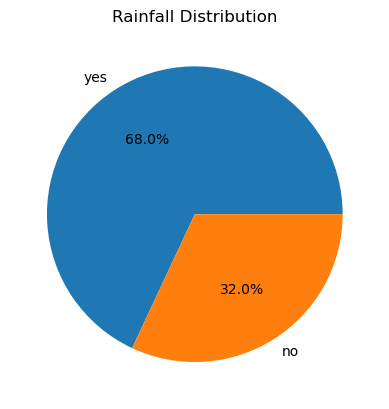

Features: ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']


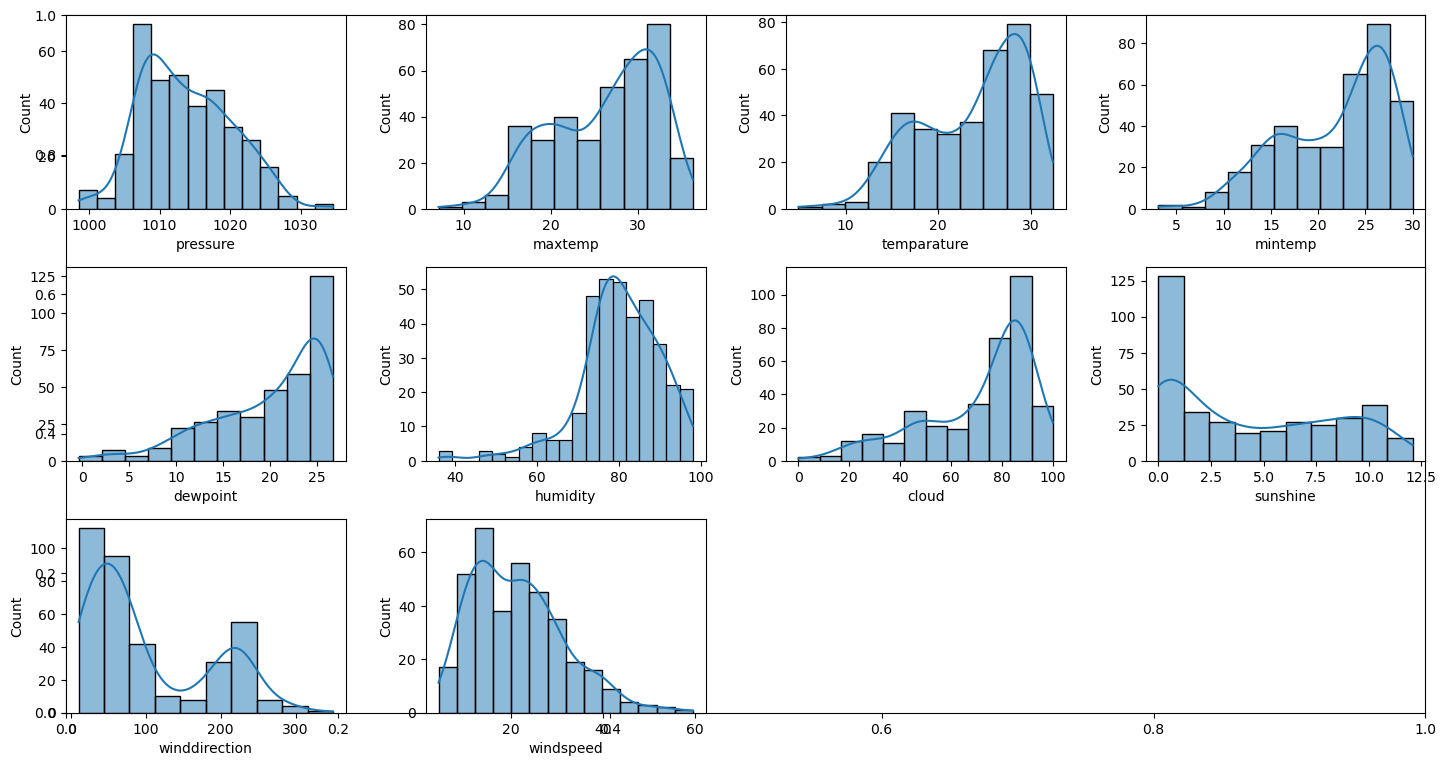

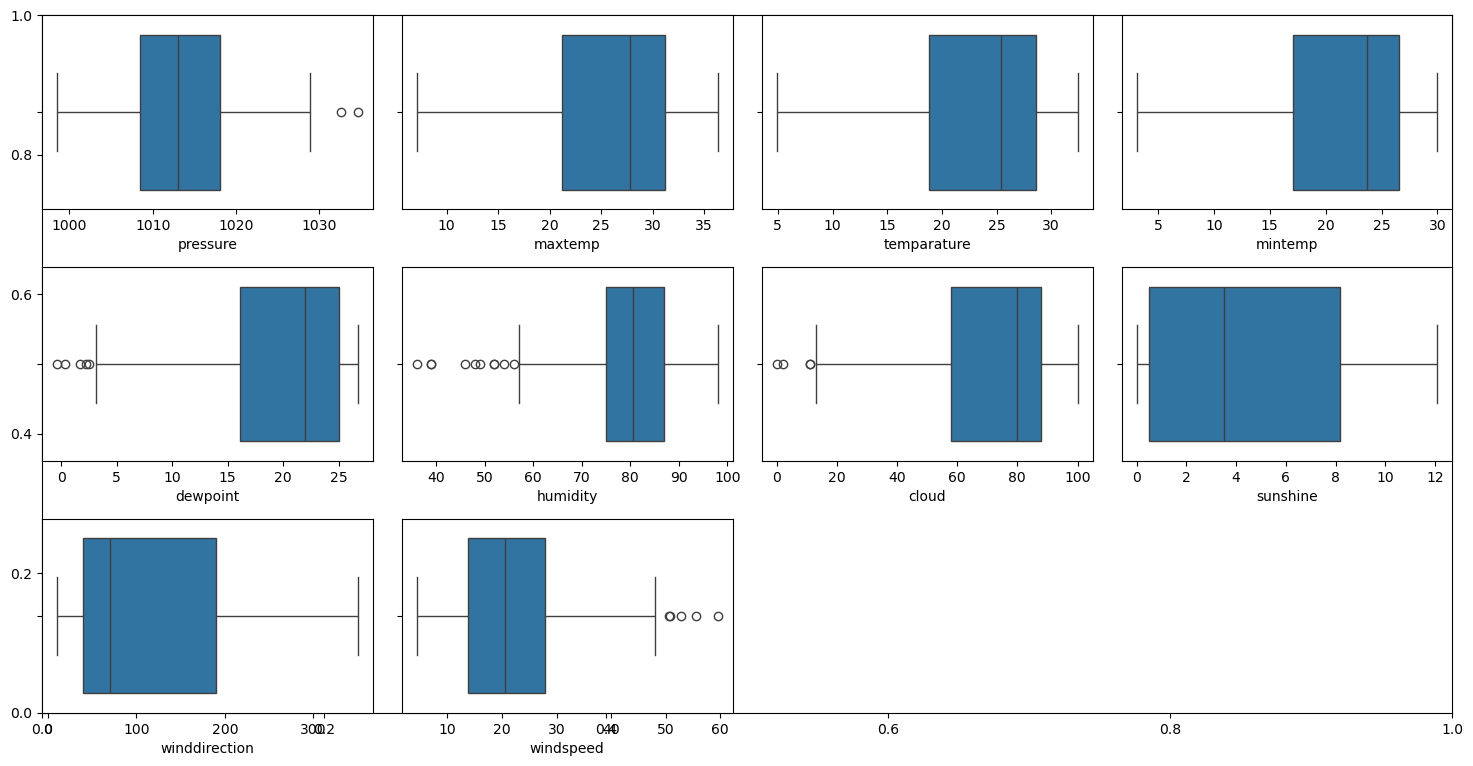

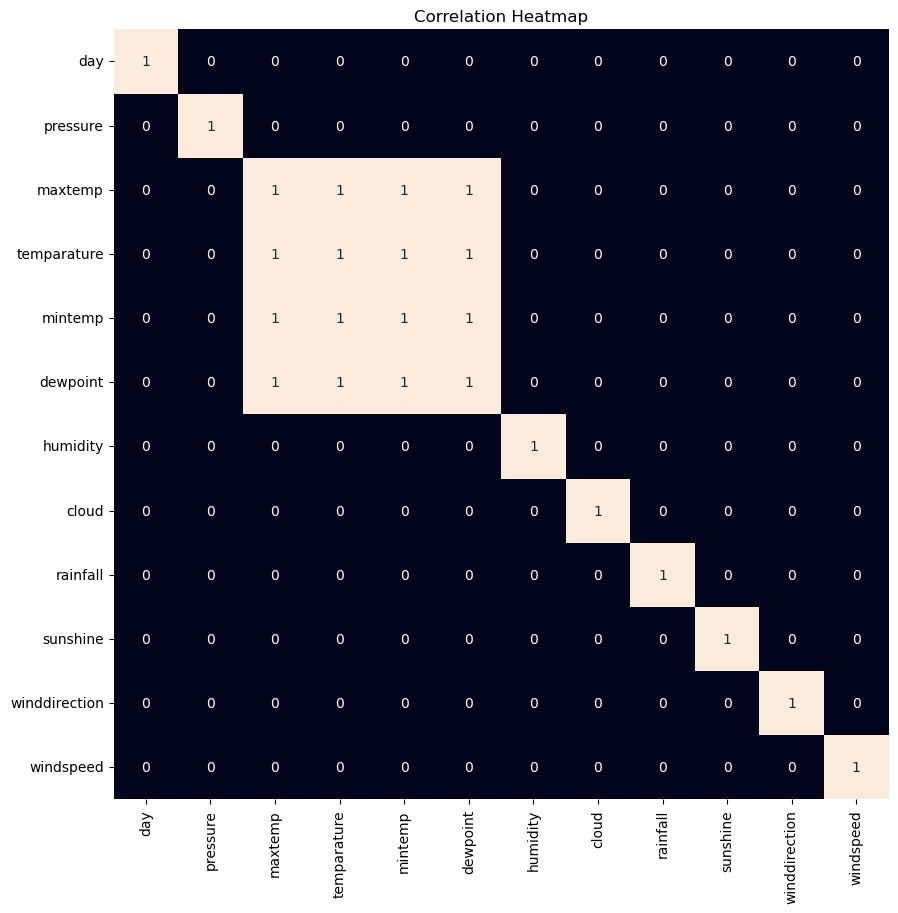

LogisticRegression :
Training ROC AUC: 0.8893209767430116
Validation ROC AUC: 0.8966666666666667

SVC :
Training ROC AUC: 0.9026792252720891
Validation ROC AUC: 0.8858333333333333



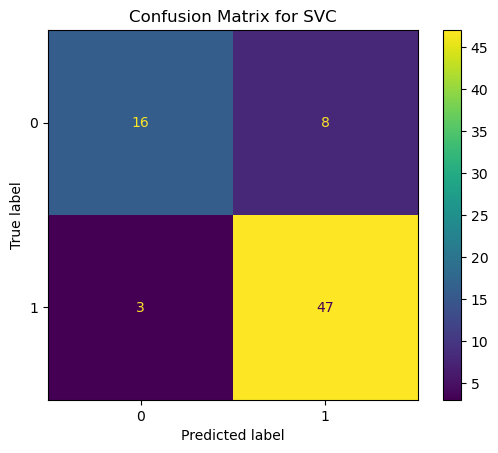

              precision    recall  f1-score   support

           0       0.84      0.67      0.74        24
           1       0.85      0.94      0.90        50

    accuracy                           0.85        74
   macro avg       0.85      0.80      0.82        74
weighted avg       0.85      0.85      0.85        74



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('Rainfall.csv')

# Data inspection
print(df.head())
print(df.shape)
print(df.info())
print(df.describe().T)

# Handle missing values
df.rename(str.strip, axis='columns', inplace=True)
for col in df.columns:
    if df[col].isnull().sum() > 0:
        val = df[col].mean()
        df[col] = df[col].fillna(val)

# Check for missing values
print("Total missing values:", df.isnull().sum().sum())

# Visualize the target distribution
plt.pie(df['rainfall'].value_counts().values,
        labels=df['rainfall'].value_counts().index,
        autopct='%1.1f%%')
plt.title('Rainfall Distribution')
plt.show()

# Feature selection
features = list(df.select_dtypes(include=np.number).columns)
features.remove('day')
print("Features:", features)

# Visualize feature distributions
plt.subplots(figsize=(15, 8))
for i, col in enumerate(features):
    plt.subplot(3, 4, i + 1)
    sb.histplot(df[col], kde=True)
plt.tight_layout()
plt.show()

# Visualize feature boxplots
plt.subplots(figsize=(15, 8))
for i, col in enumerate(features):
    plt.subplot(3, 4, i + 1)
    sb.boxplot(x=df[col])
plt.tight_layout()
plt.show()

# Encode categorical target
df.replace({'yes': 1, 'no': 0}, inplace=True)

# Correlation heatmap
plt.figure(figsize=(10, 10))
sb.heatmap(df.corr() > 0.8, annot=True, cbar=False)
plt.title('Correlation Heatmap')
plt.show()

# Drop highly correlated features
df.drop(['maxtemp', 'mintemp'], axis=1, inplace=True)

# Define features and target
features = df.drop(['day', 'rainfall'], axis=1)
target = df['rainfall']

# Split the data
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, stratify=target, random_state=2)

# Balance the dataset
ros = RandomOverSampler(sampling_strategy='minority', random_state=22)
X, Y = ros.fit_resample(X_train, Y_train)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)

# Define models
models = [LogisticRegression(), SVC(kernel='rbf', probability=True)]

# Train and evaluate models
for model in models:
    model.fit(X, Y)
    print(f'{model.__class__.__name__} :')  # Fixed class name print
    train_preds = model.predict_proba(X)
    print('Training ROC AUC:', metrics.roc_auc_score(Y, train_preds[:, 1]))
    val_preds = model.predict_proba(X_val)
    print('Validation ROC AUC:', metrics.roc_auc_score(Y_val, val_preds[:, 1]))
    print()

# Confusion matrix for SVC
ConfusionMatrixDisplay.from_estimator(models[1], X_val, Y_val)
plt.title('Confusion Matrix for SVC')
plt.show()

# Classification report for SVC
print(metrics.classification_report(Y_val, models[1].predict(X_val)))
